In [1]:
import numpy as np
import pandas as pd
import pyspark 
from pyspark import *
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

In [2]:
df = sqlContext.sql("SELECT * FROM customer_churn_csv2")

In [3]:
df.columns

Out[ 142 ]: 
['index',
 'state',
 'account length',
 'area code',
 'phone number',
 'international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'churn']

In [4]:
vector_assembler = VectorAssembler(inputCols = ['international plan','voice mail plan','number vmail messages','total day minutes','total day calls','total day charge','total night minutes','total intl minutes','total intl calls','total intl charge','customer service calls'],outputCol = "features")


In [5]:
vectorised_df = vector_assembler.transform(df)

In [6]:
str_indexer = StringIndexer(inputCol = "churn" , outputCol = 'label')

In [7]:
indexed_vectorised_df = str_indexer.fit(vectorised_df).transform(vectorised_df)

In [8]:
df = indexed_vectorised_df
df.show(1)

+-----+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+--------------------+-----+
index|state|account length|area code|phone number|international plan|voice mail plan|number vmail messages|total day minutes|total day calls|total day charge|total eve minutes|total eve calls|total eve charge|total night minutes|total night calls|total night charge|total intl minutes|total intl calls|total intl charge|customer service calls|churn| features|label|
+-----+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+--------------------+-----+
 0| KS| 128| 415| 382-4657| 0| 1| 25| 265.1| 110| 45.07| 197.4| 99| 16.78| 244.7| 91| 11.01| 10.0| 3| 2.7| 1|False|[0.0,1.0,25.0,265...| 0.0|
+-----+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+--------------------+-----+
only showing top 1 row

In [9]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
splits = df.randomSplit([0.61,0.39],seed = 1)

In [11]:
training_df = splits[0]
test_df = splits[1]

In [12]:
print(training_df.count())
print(test_df.count())

2039
1294

In [13]:
dt_definition  = DecisionTreeClassifier(labelCol = 'label',featuresCol = 'features')

In [14]:
dt_model = dt_definition.fit(training_df)

In [15]:
dt_df = dt_model.transform(test_df)

In [16]:
dt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'accuracy')

In [17]:
dt_accuracy  = dt_evaluator.evaluate(dt_df)
dt_accuracy

Out[ 156 ]: 0.9258114374034003

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [19]:
rf_def = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=15)

In [20]:
rf_model = rf_def.fit(training_df)

In [21]:
rf_df = rf_model.transform(test_df)

In [22]:
rf_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'accuracy')
rf_accuracy  = rf_evaluator.evaluate(rf_df)
rf_accuracy

Out[ 161 ]: 0.9289026275115919

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [25]:
gbt_def = GBTClassifier(labelCol="label", featuresCol="features", maxIter=25)

In [26]:
gbt_model = gbt_def.fit(training_df)

In [27]:
gbt_df = gbt_model.transform(test_df)

In [28]:
gbt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'accuracy')
gbt_accuracy  = gbt_evaluator.evaluate(gbt_df)
gbt_accuracy

Out[ 166 ]: 0.9289026275115919

In [30]:
# calculating precision and recall 

In [31]:
predictions = dt_df.select('Label', 'prediction', 'probability')
predictions.toPandas().head(5)

Out[ 168 ]: 
 Label prediction probability
0 0.0 0.0 [0.98, 0.02]
1 0.0 0.0 [0.98, 0.02]
2 0.0 0.0 [0.98, 0.02]
3 1.0 1.0 [0.02, 0.98]
4 0.0 0.0 [0.991935483871, 0.00806451612903]

In [32]:
dt_evaluator.explainParam("metricName")

Out[ 169 ]: 'metricName: metric name in evaluation (f1|weightedPrecision|weightedRecall|accuracy) (default: f1, current: accuracy)'

In [33]:
dt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'accuracy')
dt_accuracy  = dt_evaluator.evaluate(dt_df)
dt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'weightedPrecision')
dt_precision  = dt_evaluator.evaluate(dt_df)
dt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'weightedRecall')
dt_recall  = dt_evaluator.evaluate(dt_df)
dt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'f1')
dt_f1  = dt_evaluator.evaluate(dt_df)
print('Decision Tree Model Evaluation')
print('accuracy is  : ',dt_accuracy)
print('Precision is : ',dt_precision)
print('Recall is    : ',dt_recall)
print('F1 Score is  : ',dt_f1)

Decision Tree Model Evaluation
accuracy is : 0.9258114374034003
Precision is : 0.9216124499011933
Recall is : 0.9258114374034003
F1 Score is : 0.9225775091532902

In [34]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Create (prediction, label) pairs
predictionAndLabel = dt_df.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print ("The Confusion Matrix of Decision Tree Model is \n",metrics.confusionMatrix().toArray())


The Confusion Matrix of Decision Tree Model is 
 [[ 1088. 32.]
 [ 64. 110.]]

In [35]:
rf_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'accuracy')
rf_accuracy  = rf_evaluator.evaluate(rf_df)
rf_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'weightedPrecision')
rf_precision  = rf_evaluator.evaluate(rf_df)
rf_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'weightedRecall')
rf_recall  = rf_evaluator.evaluate(rf_df)
rf_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'f1')
rf_f1  = rf_evaluator.evaluate(rf_df)
print('Random Forest Model Evaluation')
print('accuracy is  : ',rf_accuracy)
print('Precision is : ',rf_precision)
print('Recall is    : ',rf_recall)
print('F1 Score is  : ',rf_f1)

Random Forest Model Evaluation
accuracy is : 0.9289026275115919
Precision is : 0.9251875575661995
Recall is : 0.9289026275115919
F1 Score is : 0.9226901155900634

In [36]:
# Create (prediction, label) pairs
predictionAndLabel = rf_df.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print ("The Confusion Matrix of Random Forest Model is \n",metrics.confusionMatrix().toArray())


The Confusion Matrix of Random Forest Model is 
 [[ 1103. 17.]
 [ 75. 99.]]

In [37]:
gbt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'accuracy')
gbt_accuracy  = gbt_evaluator.evaluate(gbt_df)
gbt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'weightedPrecision')
gbt_precision  = gbt_evaluator.evaluate(gbt_df)
gbt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'weightedRecall')
gbt_recall  = gbt_evaluator.evaluate(gbt_df)
gbt_evaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction',metricName = 'f1')
gbt_f1  = gbt_evaluator.evaluate(gbt_df)
print('Gradient Boosted Trees Model Evaluation')
print('accuracy is  : ',gbt_accuracy)
print('Precision is : ',gbt_precision)
print('Recall is    : ',gbt_recall)
print('F1 Score is  : ',gbt_f1)

Gradient Boosted Trees Model Evaluation
accuracy is : 0.9289026275115919
Precision is : 0.9246115686339399
Recall is : 0.928902627511592
F1 Score is : 0.9244422487531883

In [38]:
# Create (prediction, label) pairs
predictionAndLabel = gbt_df.select("prediction", "label").rdd

# Generate confusion matrix
metrics = MulticlassMetrics(predictionAndLabel)
print ("The Confusion Matrix of Gradient Boosted Trees Model is \n",metrics.confusionMatrix().toArray())


The Confusion Matrix of Gradient Boosted Trees Model is 
 [[ 1096. 24.]
 [ 68. 106.]]

In [39]:
# ROC curve plotting
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [40]:
predictionAndLabel = dt_df.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabel)

dt_confusion_matrix = metrics.confusionMatrix().toArray()
True_positive = dt_confusion_matrix[0][0]
False_negative = dt_confusion_matrix[0][1]
False_positive = dt_confusion_matrix[1][0]
True_negative = dt_confusion_matrix[1][0]

x = metrics.weightedFalsePositiveRate
y = metrics.weightedTruePositiveRate

In [41]:
True_positive_rate = True_positive/(True_positive + False_negative)
False_positive_rate = False_positive/(False_positive + True_negative)
print(False_positive_rate)
print(True_positive_rate)

0.5
0.971428571429

In [42]:
import matplotlib.pyplot as plt
import numpy as np

In [43]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [44]:
y_test = np.array(test_df.select("churn").collect())

In [45]:
y_pred_class = np.array(dt_df.select("Prediction").collect())

In [46]:
fpr, tpr, threshold = roc_curve(y_test,y_pred_class,pos_label='True')

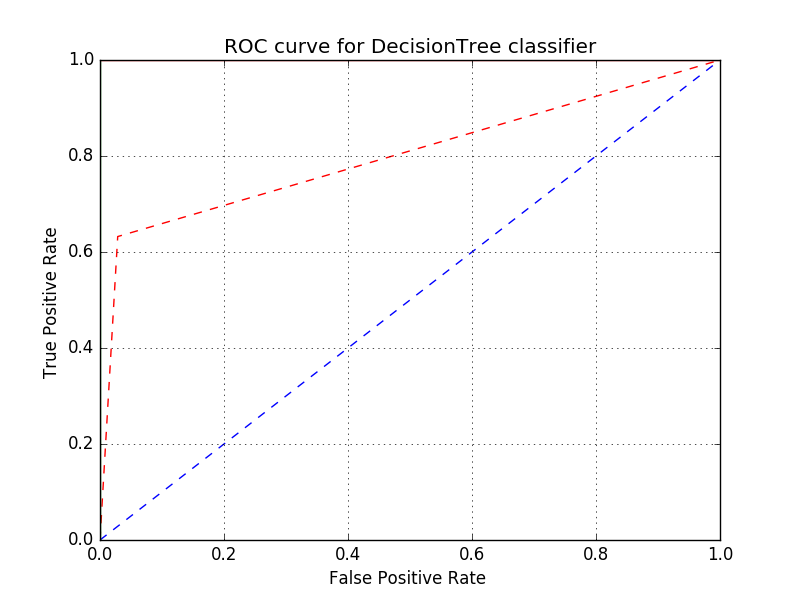

In [47]:
fig, ax = plt.subplots()
ax.plot(fpr,tpr, 'r--')
ax.plot([0, 1], ls="--")
ax.plot([0, 0], [1, 0]  ), plt.plot([1, 1] )
ax.set_title('ROC curve for DecisionTree classifier')
ax.set_xlabel('False Positive Rate ')
ax.set_ylabel('True Positive Rate ')
ax.grid(True)
display(fig)



In [48]:
y_test = np.array(test_df.select("churn").collect())
y_pred_class = np.array(rf_df.select("Prediction").collect())
fpr, tpr, threshold = roc_curve(y_test,y_pred_class,pos_label='True')

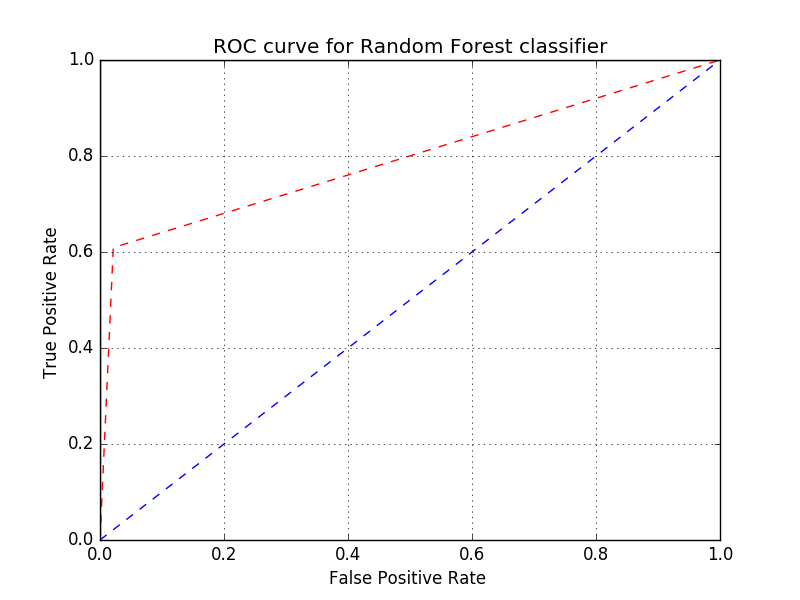

In [49]:
fig, ax = plt.subplots()
ax.plot(fpr,tpr, 'r--')
ax.plot([0, 1], ls="--")
ax.plot([0, 0], [1, 0]  ), plt.plot([1, 1] )
ax.set_title('ROC curve for Random Forest classifier')
ax.set_xlabel('False Positive Rate ')
ax.set_ylabel('True Positive Rate ')
ax.grid(True)
display(fig)

In [50]:
y_test = np.array(test_df.select("churn").collect())
y_pred_class = np.array(gbt_df.select("Prediction").collect())
fpr, tpr, threshold = roc_curve(y_test,y_pred_class,pos_label='True')

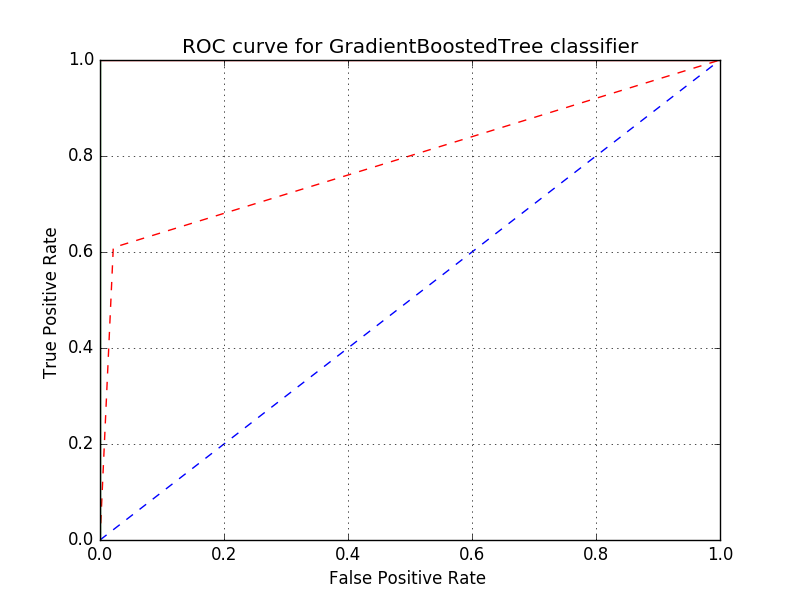

In [51]:
fig, ax = plt.subplots()
ax.plot(fpr,tpr, 'r--')
ax.plot([0, 1], ls="--")
ax.plot([0, 0], [1, 0]  ), plt.plot([1, 1] )
ax.set_title('ROC curve for GradientBoostedTree classifier')
ax.set_xlabel('False Positive Rate ')
ax.set_ylabel('True Positive Rate ')
ax.grid(True)
display(fig)

In [52]:
# learning curve 